In [6]:
# トラッキング関数
# 入力
# centroids = DataFrame, column0~4: X, Y, Z, T, ID
# 出力
# track_forward: X, Y, Z, T, ID, TrackID
# track_backward: X, Y, Z, T, ID, TrackID
# track_forward['TrackID']: forwardトラッキングされたID
# track_backward['TrackID']: backwardトラッキングされたIDに変換

def tracking(centroids, dist_thre):
    import numpy as np
    from scipy.spatial.distance import pdist, squareform
    
    t = np.max(centroids.loc[:,'T'])
    t = np.uint16(t)
    
    ID = centroids['ID']
    forward = pd.DataFrame(index=[])
    backward = pd.DataFrame(index=[])
    for i in range(t):
        # time=iの部分だけ取り出す
        lines = np.isin(np.array(centroids.loc[:,'T']), np.array([i, i+1]))
        xyz = centroids.loc[lines,['X', 'Y', 'Z']]
        tt = centroids.loc[lines,'T']
        this_id = centroids.loc[lines,'ID']
        # pdistは2次元必要なので
        t_df = pd.DataFrame(tt)
        t_df["t1"] = tt
        # 最短距離のindex, dist
        xyz_dist = pdist(xyz)
        t_dist = pdist(t_df)
        xyz_dist[t_dist==0]=10000 # 対角成分の0を100にしておく
        xyz_mat = squareform(xyz_dist)
        xyz_mat[xyz_mat==0]=10000 # 対角成分の0を100にしておく
        index = np.argmin(xyz_mat, axis=1)
        dist = np.min(xyz_mat, axis=1)
        # pre, postタイムポイントのlines
        pre_lines = list(tt==i)
        post_lines = list(tt==i+1)
        # Nearest neighbor をforward, backwardにまとめる
        # pre->post のindex, dist
        if i!=t and pre_lines: # pre_linesが空の場合は処理しない
            fi = pd.DataFrame(this_id[pre_lines], columns=['ID'])
            fi['PostID'] = np.array(this_id)[index][pre_lines]
            fi['T'] = tt[pre_lines]
            fi['Dist'] = np.array(dist)[pre_lines]
            forward = forward.append(fi)
        # post->pre のindex, dist
        if post_lines: # post_linesが空の場合は処理しない
            bi = pd.DataFrame(this_id[post_lines], columns=['ID'])
            bi['PreID'] = np.array(this_id)[index][post_lines]
            bi['T'] = tt[post_lines]
            bi['Dist'] = np.array(dist)[post_lines]
            backward = backward.append(bi)
        
    # forwardの関係を用いてIDを変換することでトラッキングする
    forward_ID = ID.copy()
    pre = forward['ID']
    post = forward['PostID']
    time = forward['T']
    dist = forward['Dist']
    for j in range(t-1, -1, -1):
        this_pre = pre[time==j]
        this_post = post[time==j]
        this_dist = dist[time==j]
        # 距離しきい値の適用
        this_pre = this_pre[this_dist < dist_thre]
        this_post = this_post[this_dist < dist_thre]
        # 辞書にすることで一括変換できる
        post_pre_dict = dict(zip(this_post, this_pre))
        forward_ID.replace(post_pre_dict, inplace=True)
    # backwardの関係を用いてIDを変換することでトラッキングする
    backward_ID = ID.copy()
    pre = backward['PreID']
    post = backward['ID']
    time = backward['T']
    dist = backward['Dist']
    for j in range(t, 0, -1):
        this_pre = pre[time==j]
        this_post = post[time==j]
        this_dist = dist[time==j]
        # 距離しきい値の適用
        this_pre = this_pre[this_dist < dist_thre]
        this_post = this_post[this_dist < dist_thre]
        # 辞書にすることで一括変換できる
        post_pre_dict = dict(zip(this_post, this_pre))
        backward_ID.replace(post_pre_dict, inplace=True)
        
    # return forward, backward, forward_ID, backward_ID
    
    # centroidsにトラッキングIDを追加して返す
    track_forward = centroids.copy()
    track_forward['TrackID'] = forward_ID
    track_backward = centroids.copy()
    track_backward['TrackID'] = backward_ID
    
    return track_forward, track_backward

In [7]:
# 領域を四角で囲んだ画像を作成する関数
# 入力
# centroids: DataFrame, column0~5: X, Y, Z, T, ID, TrackID
# image_size: T, Z, Row, Column
# 出力
# mask: 軌跡を描画した画像

def draw_rectangles(centroids, image_size, width=9):
    import numpy as np
    from skimage.draw import rectangle_perimeter
    
    # 結果はmask画像
    mask = np.zeros(image_size, dtype=bool)
    
    # TrackIDごとに処理する
    ids = centroids['TrackID'].unique()
    for id_ in ids:
        # mask_tempに２タイムポイント間の移動を描画する
        ts = centroids.loc[centroids['TrackID']==id_, 'T']
        
        for t in ts:
            ind = (centroids.loc[:,'T']==(t)) & (centroids['TrackID']==id_)
            cent = centroids.loc[ind,['Y','X']]
            # ndarrayに変換
            cent = cent.values
            cent = cent[0]
            # 開始点と終了点
            start = cent - (width - 1)/2
            end = cent + (width - 1)/2
            # 描画
            r, c = rectangle_perimeter(start, end, shape=image_size[2:4])
            temp_mask = np.zeros(image_size[2:4], dtype=bool)
            temp_mask[r,c] = 1
            # maskに足し合わせる
            t = np.uint8(t)
            z = np.uint8(np.round(centroids.loc[ind,'Z']))
            mask[t,z,:,:] = mask[t,z,:,:] + temp_mask
    
    return mask

In [8]:
# 軌跡を描画した画像を作成する関数
# 入力
# centroids: DataFrame, column0~5: X, Y, Z, T, ID, TrackID
# image_size: T, Z, Row, Column
# n_frame:軌跡を残すフレーム数
# 出力
# mask: 軌跡を描画した画像

def draw_trajectories(centroids, image_size, n_frame=10):
    import numpy as np
    from skimage.draw import line_nd
    
    # 結果はmask画像
    mask = np.zeros(image_size, dtype=bool)
    
    # TrackIDごとに処理する
    ids = centroids['TrackID'].unique()
    for id_ in ids:
        # mask_tempに２タイムポイント間の移動を描画する
        ts = centroids.loc[centroids['TrackID']==id_, 'T']
        ts = ts[1:] # ２タイムポイント目から処理するので
        mask_temp = np.zeros(image_size, dtype=bool)
        for t in ts:
            preline = (centroids.loc[:,'T']==(t-1)) & (centroids['TrackID']==id_)
            pre = centroids.loc[preline,['T','Z','Y','X']]
            postline = (centroids.loc[:,'T']==(t)) & (centroids['TrackID']==id_)
            post = centroids.loc[postline,['T','Z','Y','X']]
            # ndarrayに変換
            pre = pre.values
            pre = pre[0]
            post = post.values
            post = post[0]
            # 線を描画
            lin = line_nd(pre, post, endpoint=False)
            mask_temp[lin] = 1
            
        #軌跡を指定したタイムポイント分残すため、前の画像を足し合わせる
        mask_sum = mask_temp.copy()
        for t in ts:
            iniT = np.max([np.min(ts), t-n_frame])
            mask_sum[t,:,:,:] = np.sum(mask_temp[list(range(iniT,t+1)),:,:,:], axis=0)
            
        # maskにmask_tempを足していく
        mask = mask + mask_sum
    
    return mask
    

In [9]:
# トラッキングの実行
import pandas as pd

centroids = pd.read_csv('./Sample/centroids.csv', header=0)
# centroids = pd.read_csv('./Sample/centroids_short.csv', header=0)
track_forward, track_backward = tracking(centroids, 15)

print(track_forward)

               X          Y          Z    T    ID  TrackID
0      57.800413  48.682990  20.737829    0     0        0
1     110.418416  77.415149  23.825473    0     1        1
2     107.326827  78.527159  23.521842    1     2        1
3      57.969858  48.703400  25.136992    1     3        0
4     105.764560  78.108566  22.742584    2     4        1
...          ...        ...        ...  ...   ...      ...
7942   54.093171  36.968904  40.967115  239  7942      126
7943   88.662202  50.566530  41.753894  239  7943     4714
7944   89.369811  92.431472  42.639687  239  7944      615
7945   58.624904  49.117113  42.063927  239  7945     5000
7946  104.386983  81.276652  41.795918  239  7946     1652

[7947 rows x 6 columns]


In [10]:
# 軌跡の描画を実行
from tifffile import imwrite 

image_size = [240,52,127,146]
# image_size = [30,52,127,146]
rectangle = draw_rectangles(track_forward, image_size)
line = draw_trajectories(track_forward, image_size)
mask = rectangle + line
# save
imwrite('./mask.tif', mask, photometric='minisblack')

In [11]:
# 4D画像の可視化ツール
# img4D = [t, z, r, c]
# img3D = [z, r, c]
# img2D = [r, c]
# 2~4D画像全てで同じUI

def viewer4D(img):
    # Notebook内・インタラクティブモード
    %matplotlib notebook
    import matplotlib.pyplot as plt
    from ipywidgets import Play, IntSlider, jslink, HBox, VBox, interactive_output
    
    # カラーマップを変更する場合
    # plt.rcParams['image.cmap'] = 'jet'
    
    def show_img(z, t):
        if img.ndim==4:
            ax1.cla()
            ax1.imshow(img[t,z,:,:])
        elif img.ndim==3:
            ax1.cla()
            ax1.imshow(img[z,:,:])
        elif img.ndim==2:
            ax1.cla()
            ax1.imshow(img)
            
    # Figureの初期化, Axesを追加
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    # range
    if img.ndim==4:
        # T1
        playT = Play(value=1, min=0, max=img.shape[0]-1, step=1, interval=500, description="T")
        sliderT = IntSlider(min=0, max=img.shape[0]-1, description="T")
        jslink((playT, 'value'), (sliderT, 'value'))
        # Z1
        playZ = Play(value=1, min=0, max=img.shape[1]-1, step=1, interval=500, description="Z")
        sliderZ = IntSlider(min=0, max=img.shape[1]-1, description="Z")
        jslink((playZ, 'value'), (sliderZ, 'value'))
        # 連結1
        hboxT = HBox([sliderT, playT])
        hboxZ = HBox([sliderZ, playZ])
        ui = VBox([hboxT, hboxZ])
    elif img.ndim==3:
        # T1
        playT = Play(value=1, min=0, max=0, step=1, interval=500, description="T")
        sliderT = IntSlider(min=0, max=0, description="T")
        jslink((playT, 'value'), (sliderT, 'value'))
        # Z1
        playZ = Play(value=1, min=0, max=img.shape[0]-1, step=1, interval=500, description="Z")
        sliderZ = IntSlider(min=0, max=img.shape[0]-1, description="Z")
        jslink((playZ, 'value'), (sliderZ, 'value'))
        # 連結1
        hboxT = HBox([sliderT, playT])
        hboxZ = HBox([sliderZ, playZ])
        ui = VBox([hboxT, hboxZ])
    elif img.ndim==2:
        # T1
        playT = Play(value=1, min=0, max=0, step=1, interval=500, description="T")
        sliderT = IntSlider(min=0, max=0, description="T")
        jslink((playT, 'value'), (sliderT, 'value'))
        # Z1
        playZ = Play(value=1, min=0, max=0, step=1, interval=500, description="Z")
        sliderZ = IntSlider(min=0, max=0, description="Z")
        jslink((playZ, 'value'), (sliderZ, 'value'))
        # 連結1
        hboxT = HBox([sliderT, playT])
        hboxZ = HBox([sliderZ, playZ])
        ui = VBox([hboxT, hboxZ])

    
    out = interactive_output(show_img, {'z': sliderZ, 't': sliderT})
    display(ui, out)

<IPython.core.display.Javascript object>


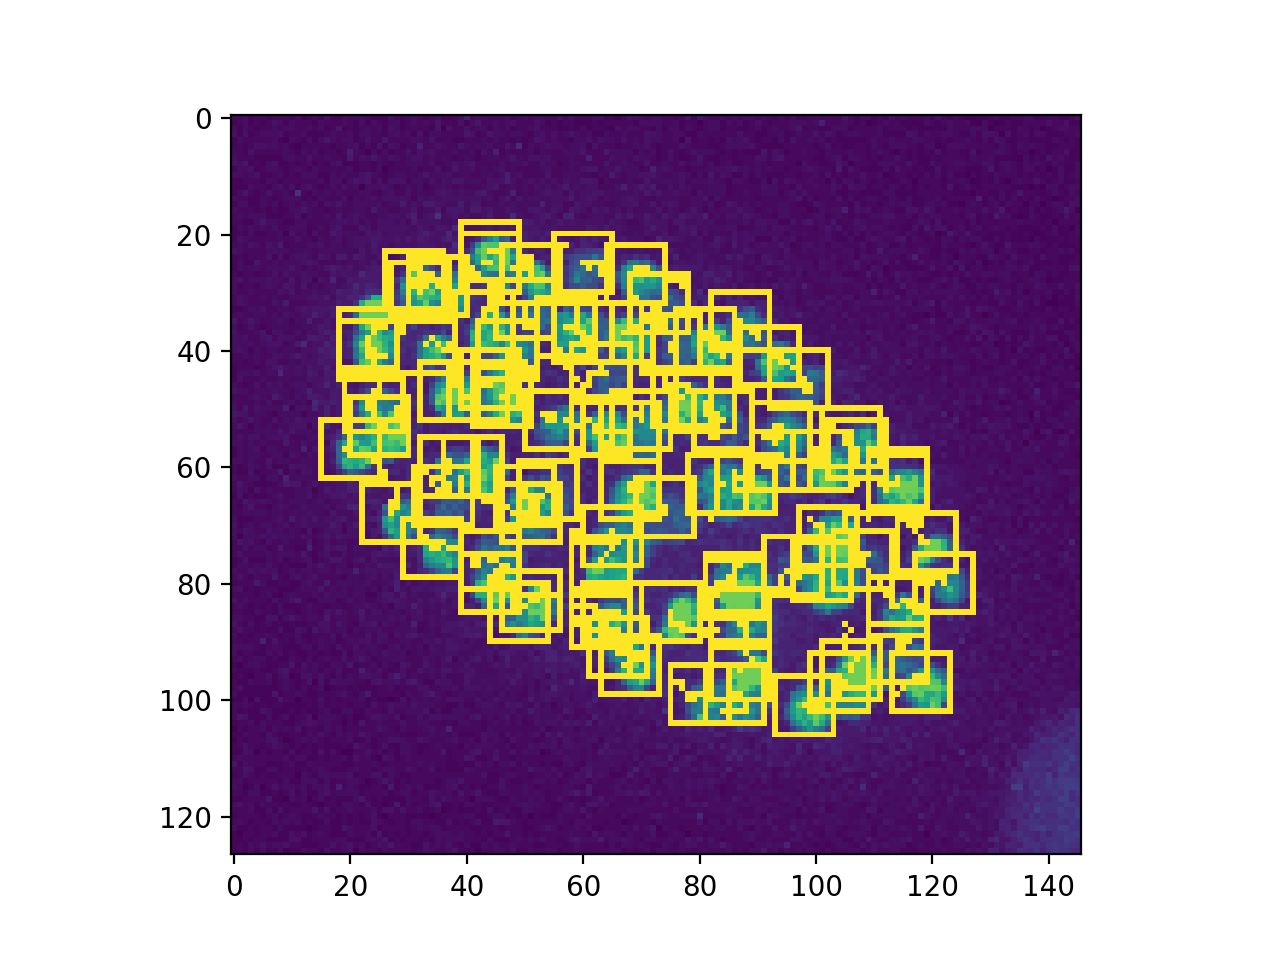

Output()

In [12]:
# 軌跡を元画像に追加

import numpy as np
from tifffile import imread

# 画像の読み込み
filename = './Sample/image_mip.tif'
# filename = './Sample/image_short_mip.tif'
img = imread(filename)

# mask画像のMIP
mask_mip = np.max(mask, axis=1)

# 画像に軌跡を描画、輝度値の調整
trajectory = (200/255) * img * ~mask_mip
trajectory = trajectory + 255 * mask_mip

# 画像表示
viewer4D(trajectory)

# 保存
trajectory = np.uint8(trajectory)
imwrite('./tracking.tif', trajectory, photometric='minisblack')